<a href="https://colab.research.google.com/github/eduardopolanc/pp1/blob/main/Outliers/exercise_outliers_meteo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Simple outlier removal on meteorological data
## Instructions
1. Load the data from the csv file (Done)
2. We are going to look at data retrived from "sensor 2", which measures temperature, humidity and pressure (columns `Temp2`, `Pression` and `hum2`). Create a new dataframe containing only these columns.
3. Use `plotly.express` to plot the points in each column. Use `px.scatter` to see only the available points without connecting lines. Zoom around and notice how the time frequency of the measuremnts is variable. Note many dates have no measurements registered. Do you see hints of outlier presence?
4. Plot histograms and use the `describe` function to visualize some statistics. Do you see hints of outlier presence?
5. Plot each column using boxplots (using `pandas.DataFrame.plot(kind='box',...)`). Do you see any outliers in the plots?
6. Try changing the whiskers limits using the parameter `whis`, and observe the difference in the number of outliers detected. Repeat the plot for the following thresholds:
    - +- 3 IQR
    - bottom 5% / top 95%
    - bottom 1% / top 99%
    - bottom 0.5% / top 99.5%
7. Based on the previous thresholds, use a simple method to remove some of the outliers.
    - Select apropriate tresholds for each column
    - You can just remove them (with a mask) or use winsorizing (`pd.clip`).
    - Save the clean data to a **new** dataframe, **do not overwrite the previous one**.
8. To exemplify the effect of removing outliers, you are going to plot a heatmat representing the correlation matrix of these columns.
    - Repeat the plot for the data with and without outliers.
    - Did you observe major changes in the correlation indexes?
    - You can use the following code to plot the correlation heatmap:
        ``` python
        sns.heatmap(data.corr(),
                    vmin=-1, vmax=1,
                    annot=True, fmt=".2f", cmap='coolwarm',
                    mask=np.tri(data.shape[1], k=-1).T)
        ```



## Useful documentation
- [Plotly express `scatter`](https://plotly.com/python-api-reference/generated/plotly.express.scatter.html)
- [Pandas `DataFrame.plot(kind=...)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib `hist`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)
- [Seaborn `histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html)
- [Matplotlib `boxplot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html)
- [Seaborn `boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html)
- [Pandas `DataFrame.clip`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html)

# Imports

In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

import plotly.express as px
#increase font size of all elements

sns.set(font_scale=1.5)


# Load the data

In [98]:
# read csv file
full_data = (pd.read_csv('/donnee_Station_Meteo.csv', sep=';',
                       index_col=1,
                       parse_dates=[1])
            .dropna(how='all')
            .drop(columns=['id',' '])
            )
display(full_data.info())
display(full_data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2018-06-22 12:00:52 to 2022-01-31 07:08:40
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp1          3036 non-null   float64
 1   hum1           3036 non-null   float64
 2   Pression       3036 non-null   float64
 3   Temp2          3036 non-null   float64
 4   hum2           3036 non-null   float64
 5   Conc_Stand_1   3036 non-null   int64  
 6   Conc_Stand_25  3036 non-null   int64  
 7   Conc_Stand_10  3036 non-null   int64  
 8   Conc_Env_1     3036 non-null   int64  
 9   Conc_Env_25    3036 non-null   int64  
 10  Conc_Env_10    3036 non-null   int64  
 11  Part_03        3036 non-null   int64  
 12  Part_05        3036 non-null   int64  
 13  Part_1         3036 non-null   int64  
 14  Part_25        3036 non-null   int64  
 15  Part_5         3036 non-null   int64  
 16  Part_50        3036 non-null   int64  
 17  Lum            3

None

,Temp1,hum1,Pression,Temp2,hum2,Conc_Stand_1,Conc_Stand_25,Conc_Stand_10,Conc_Env_1,Conc_Env_25,Conc_Env_10,Part_03,Part_05,Part_1,Part_25,Part_5,Part_50,Lum
time,,,,,,,,,,,,,,,,,,
2018-06-22 12:00:52,28.70,41.45,1011.88,29.07,50.52,6,10,22,6,10,22,0,0,0,0,0,0,51
2018-06-22 12:05:59,26.67,44.21,1011.90,26.63,53.92,6,9,9,6,9,9,1164,366,50,3,0,0,54
2018-06-22 12:11:05,25.63,46.44,1011.81,26.34,54.95,6,8,10,6,8,10,1164,340,37,5,2,0,22
2018-06-22 12:16:12,24.88,50.00,1011.77,26.07,57.26,7,8,9,7,8,9,1245,367,45,3,1,0,9
2018-06-22 12:21:19,24.95,49.12,1011.67,26.01,56.83,4,6,6,4,6,6,1182,332,28,2,0,0,11


# Select columns of interest

In [99]:
#creating new dataframe for sensor 2

Sen2df = full_data[["Temp2", "hum2", "Pression"]].copy()
Sen2df = Sen2df.dropna()
Sen2df

,Temp2,hum2,Pression
time,,,
2018-06-22 12:00:52,29.07,50.52,1011.88
2018-06-22 12:05:59,26.63,53.92,1011.90
2018-06-22 12:11:05,26.34,54.95,1011.81
2018-06-22 12:16:12,26.07,57.26,1011.77
2018-06-22 12:21:19,26.01,56.83,1011.67
...,...,...,...
2022-01-23 15:23:36,12.63,100.00,1023.85
2022-01-23 15:24:06,12.60,100.00,1023.82
2022-01-24 14:45:46,15.50,100.00,1025.13


# Visualize data points

In [101]:
px.scatter(Sen2df, y="Temp2", title = "Temperature record of sensor 2").show()
px.scatter(Sen2df, y="Pression", title = "Pressure record of sensor 2").show()
px.scatter(Sen2df, y="hum2", title = "Humidity record of sensor 2").show()

# Plot histograms


In [102]:
px.histogram(Sen2df,
             x = "Temp2",
             nbins = 30,
             title = "Histogram Temperature").show()
px.histogram(Sen2df,
             x = "hum2",
             nbins = 30,
             title = "Histogram humidity").show()
px.histogram(Sen2df,
             x = "Pression",
             nbins = 30,
             title = "Histogram Pressure").show()

'''after plotting we can observe some outlayers for humidity and pressure. On humidity we can see that most of the data is close to 100
but some data are way lower than this or even 0. On Pressure we can see the same behavior but more clear since there is a huge gap 1000 and 0.'''

'after plotting we can observe some outlayers for humidity and pressure. On humidity we can see that most of the data is close to 100\nbut some data are way lower than this or even 0. On Pressure we can see the same behavior but more clear since there is a huge gap 1000 and 0.'

# Print basic statistics wtih `describe`


In [103]:
Sen2df.describe()

#the statistics confirm the outlayers seen in the histogram. we can infer based on the quartiles that Temp2 have possible
#outlayers in the upper values, meanwhile hum2 and pressure have outlayers in the minimum values'''

,Temp2,hum2,Pression
count,3036.000000,3036.000000,3036.000000
mean,19.160418,84.246815,1006.951647
std,8.106661,26.049077,83.064496
min,0.000000,0.000000,0.000000
25%,13.360000,69.987500,1010.217500
50%,18.270000,100.000000,1013.135000
75%,25.022500,100.000000,1017.592500
max,129.370000,100.000000,1030.880000


# Plot box-plots


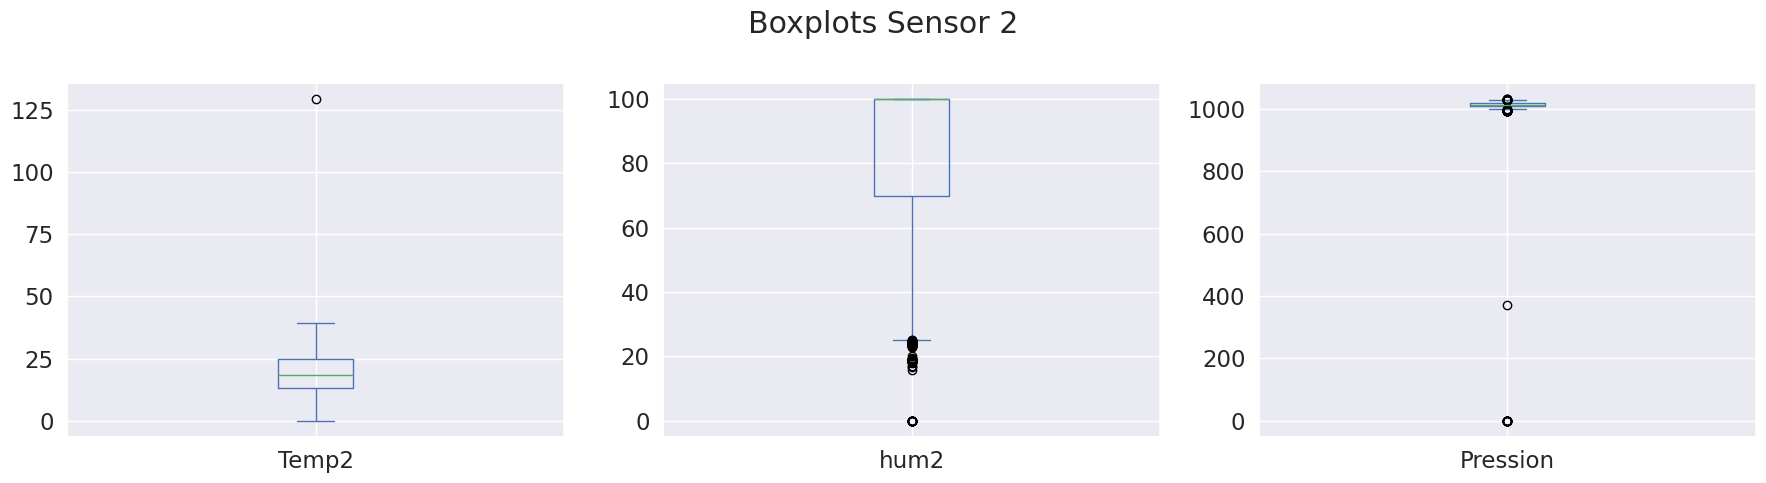

In [104]:
Sen2df[['Temp2', 'hum2', 'Pression']].plot(
    kind='box',
    subplots=True,
    layout=(1, 3),
    figsize=(18, 5),
    grid=True,
    title='Boxplots Sensor 2'
)

plt.tight_layout()
plt.show()

### Cut-out at +- 1.5 IQR

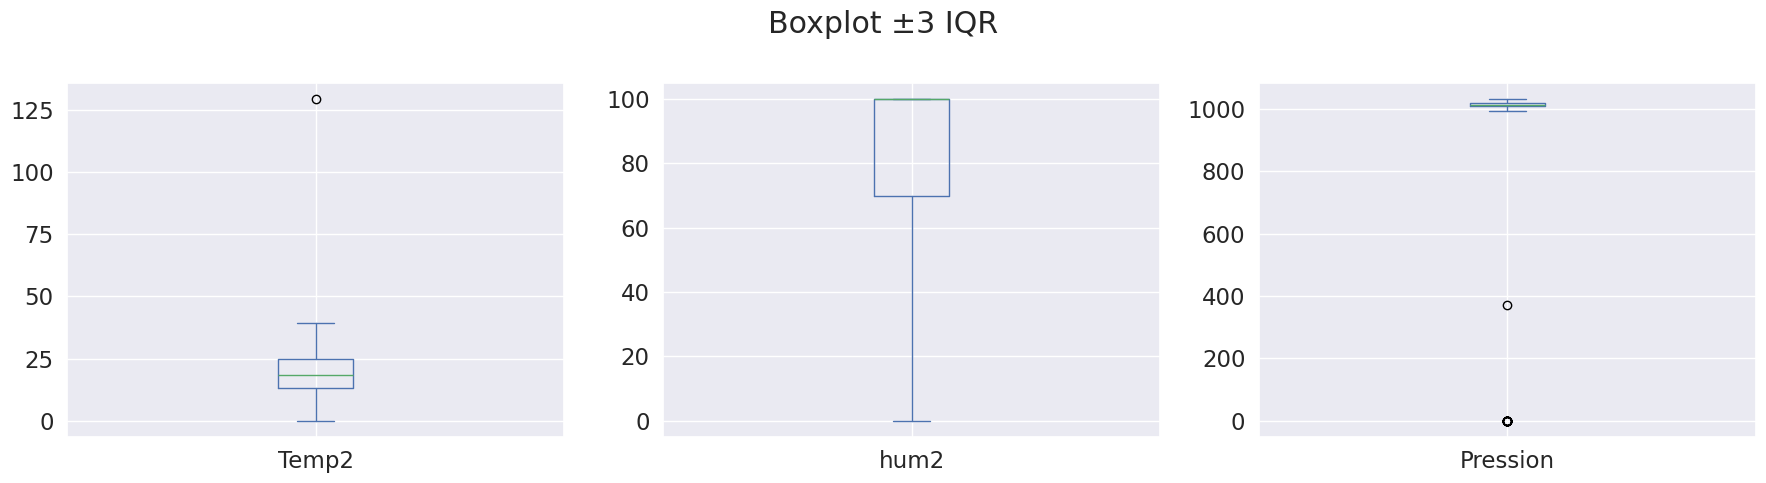

In [105]:
Sen2df[['Temp2', 'hum2', 'Pression']].plot(
    kind='box', subplots=True, layout=(1, 3), figsize=(18, 5), grid=True, whis=3,
    title='Boxplot ±3 IQR'
)
plt.tight_layout()
plt.show()

### Cut-out at 5%/95%

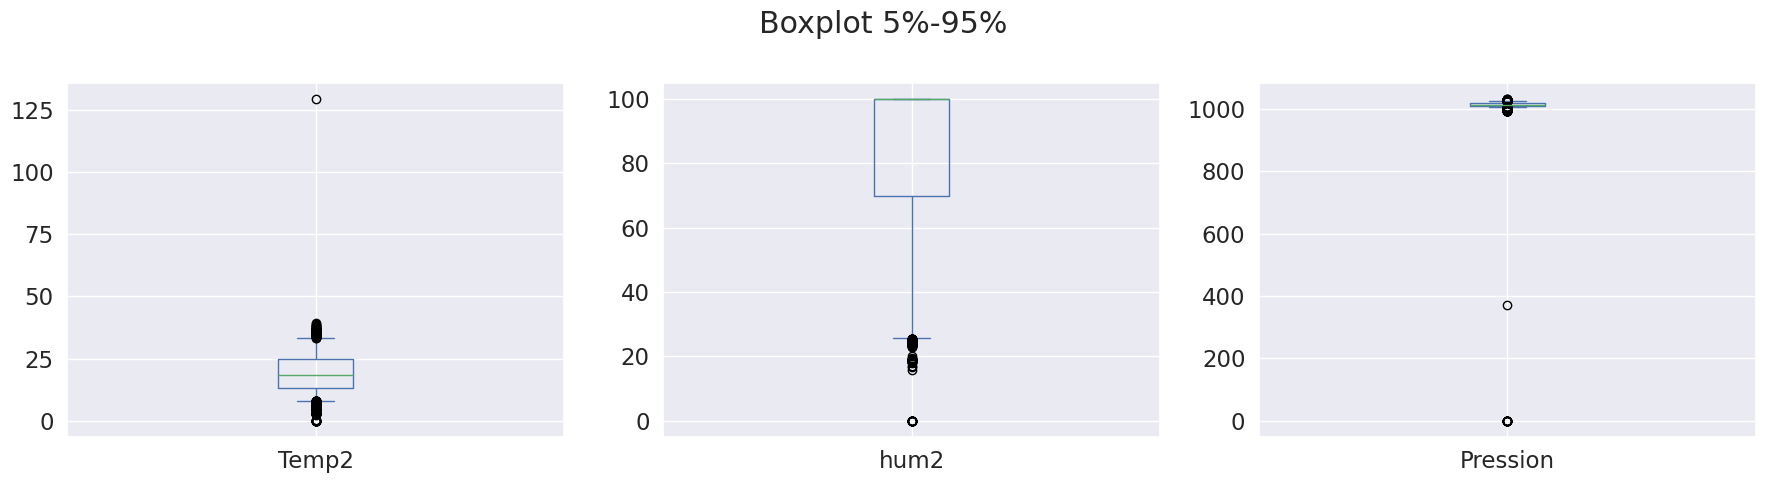

Temp2      -21.794
hum2       -61.168
Pression   -16.464
dtype: float64


In [113]:
Sen2df595 = Sen2df[['Temp2', 'hum2', 'Pression']].plot(
    kind='box', subplots=True, layout=(1, 3), figsize=(18, 5), grid=True, whis=[5, 95],
    title='Boxplot 5%-95%'
)
plt.tight_layout()
plt.show()

print(Sen2df_mask_5_95.quantile(0.05) - Sen2df_mask_5_95.quantile(0.95))

### Cut-out at 1%/99%

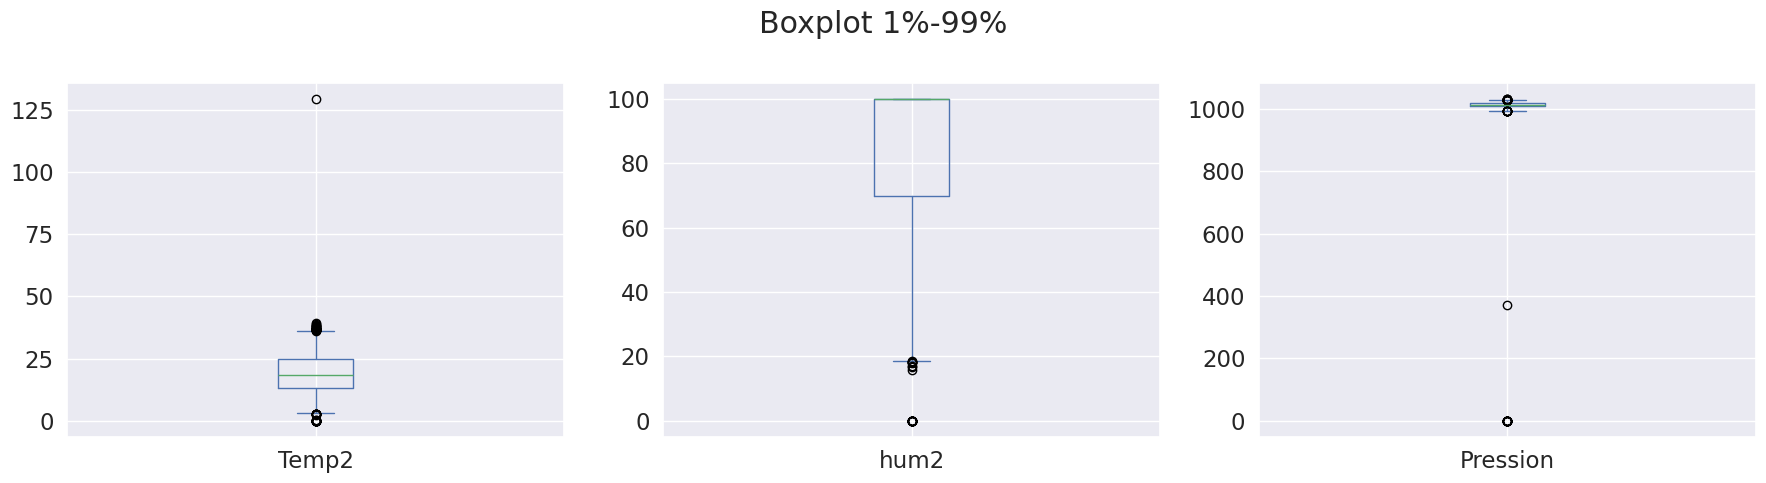

In [107]:
Sen2df[['Temp2', 'hum2', 'Pression']].plot(
    kind='box', subplots=True, layout=(1, 3), figsize=(18, 5), grid=True, whis=[1, 99],
    title='Boxplot 1%-99%'
)
plt.tight_layout()
plt.show()

### Cut-out at 0.5%/99.5%

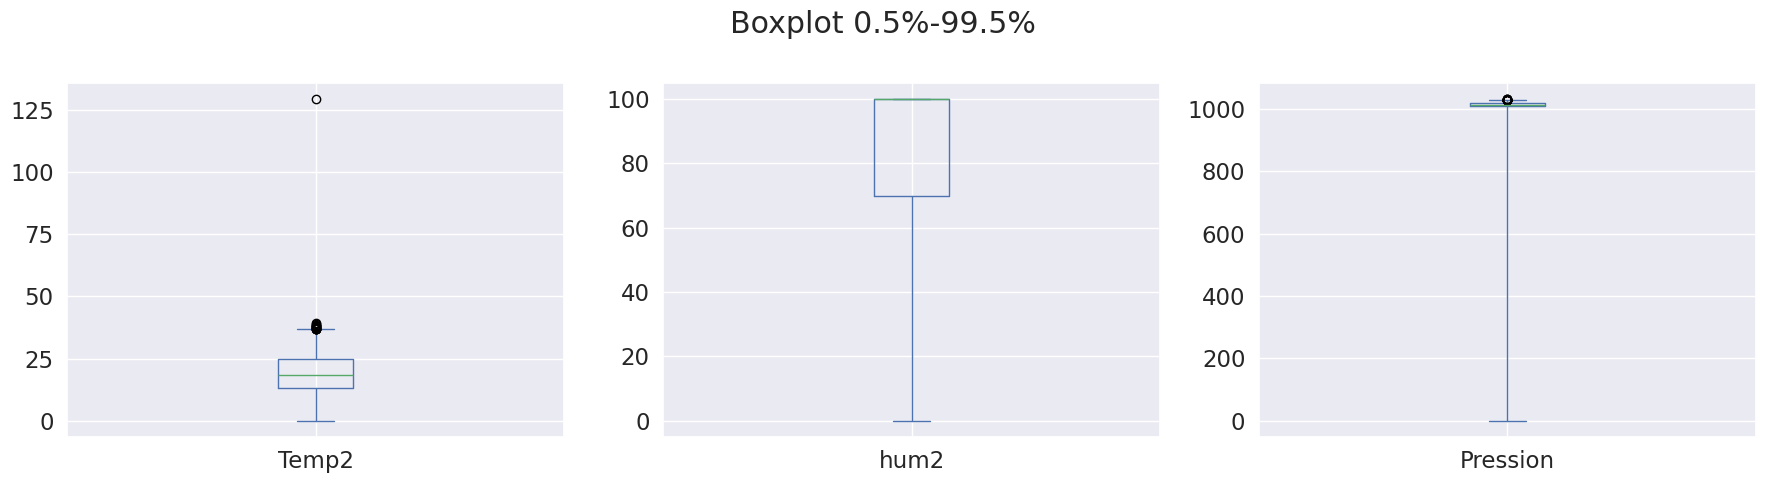

In [108]:
Sen2df[['Temp2', 'hum2', 'Pression']].plot(
    kind='box', subplots=True, layout=(1, 3), figsize=(18, 5), grid=True, whis=[0.5, 99.5],
    title='Boxplot 0.5%-99.5%'
)
plt.tight_layout()
plt.show()

# Use a simple method to remove outliers

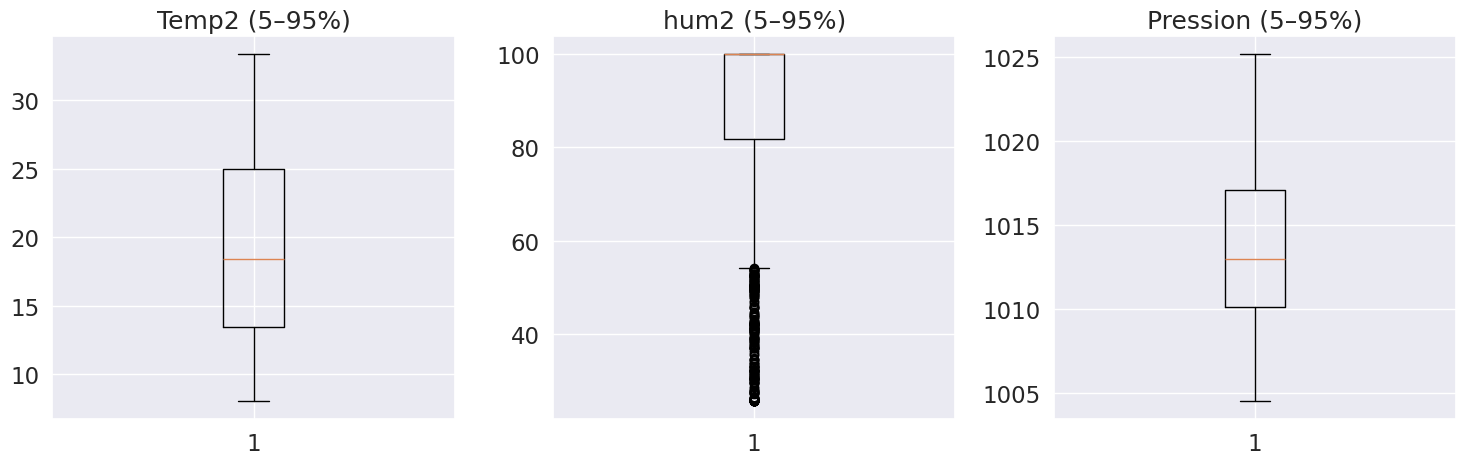

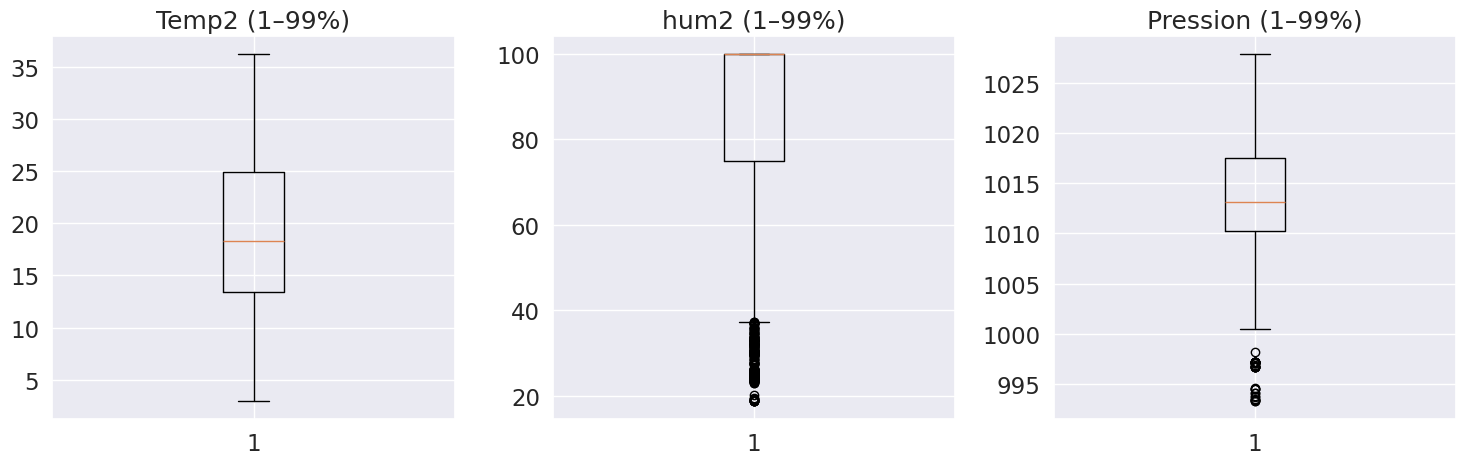

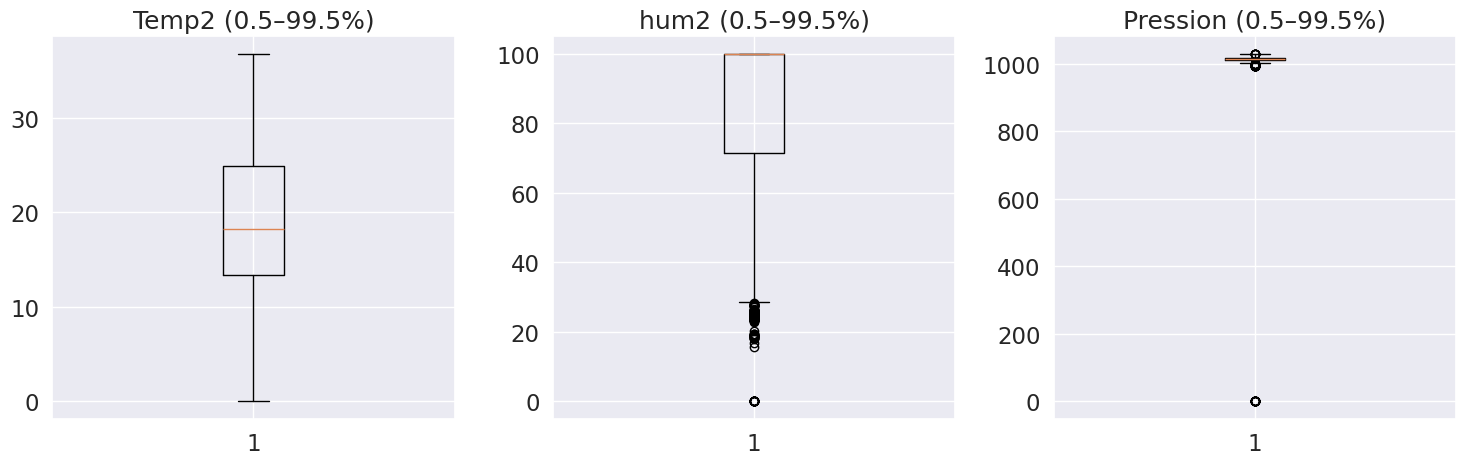

In [109]:
# --- 5%–95% ---
q5_95 = Sen2df.quantile([0.05, 0.95])
Sen2df_mask_5_95 = Sen2df[
    (Sen2df['Temp2'].between(q5_95.loc[0.05, 'Temp2'], q5_95.loc[0.95, 'Temp2'])) &
    (Sen2df['hum2'].between(q5_95.loc[0.05, 'hum2'], q5_95.loc[0.95, 'hum2'])) &
    (Sen2df['Pression'].between(q5_95.loc[0.05, 'Pression'], q5_95.loc[0.95, 'Pression']))
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].boxplot(Sen2df_mask_5_95['Temp2'])
axes[0].set_title('Temp2 (5–95%)')

axes[1].boxplot(Sen2df_mask_5_95['hum2'])
axes[1].set_title('hum2 (5–95%)')

axes[2].boxplot(Sen2df_mask_5_95['Pression'])
axes[2].set_title('Pression (5–95%)')

plt.tight_layout()
plt.show()

# --- 1%–99% ---
q1_99 = Sen2df.quantile([0.01, 0.99])
Sen2df_mask_1_99 = Sen2df[
    (Sen2df['Temp2'].between(q1_99.loc[0.01, 'Temp2'], q1_99.loc[0.99, 'Temp2'])) &
    (Sen2df['hum2'].between(q1_99.loc[0.01, 'hum2'], q1_99.loc[0.99, 'hum2'])) &
    (Sen2df['Pression'].between(q1_99.loc[0.01, 'Pression'], q1_99.loc[0.99, 'Pression']))
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].boxplot(Sen2df_mask_1_99['Temp2'])
axes[0].set_title('Temp2 (1–99%)')

axes[1].boxplot(Sen2df_mask_1_99['hum2'])
axes[1].set_title('hum2 (1–99%)')

axes[2].boxplot(Sen2df_mask_1_99['Pression'])
axes[2].set_title('Pression (1–99%)')

plt.tight_layout()
plt.show()

# --- 0.5%–99.5% ---
q05_995 = Sen2df.quantile([0.005, 0.995])
Sen2df_mask_05_995 = Sen2df[
    (Sen2df['Temp2'].between(q05_995.loc[0.005, 'Temp2'], q05_995.loc[0.995, 'Temp2'])) &
    (Sen2df['hum2'].between(q05_995.loc[0.005, 'hum2'], q05_995.loc[0.995, 'hum2'])) &
    (Sen2df['Pression'].between(q05_995.loc[0.005, 'Pression'], q05_995.loc[0.995, 'Pression']))
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].boxplot(Sen2df_mask_05_995['Temp2'])
axes[0].set_title('Temp2 (0.5–99.5%)')

axes[1].boxplot(Sen2df_mask_05_995['hum2'])
axes[1].set_title('hum2 (0.5–99.5%)')

axes[2].boxplot(Sen2df_mask_05_995['Pression'])
axes[2].set_title('Pression (0.5–99.5%)')

plt.tight_layout()
plt.show()


# Plot column correlation with outliers

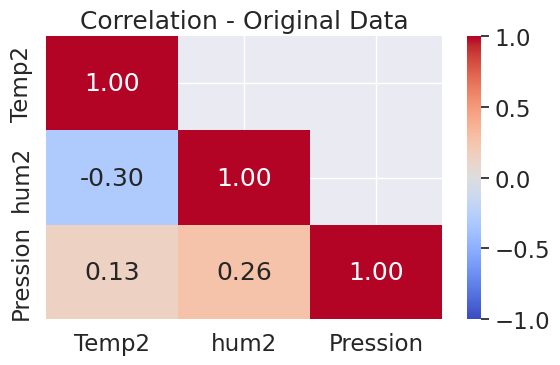

In [95]:
plt.figure(figsize=(6, 4))
sns.heatmap(Sen2df.corr(),
            vmin=-1, vmax=1,
            annot=True, fmt=".2f", cmap='coolwarm',
            mask=np.tri(Sen2df.shape[1], k=-1).T)
plt.title('Correlation - Original Data')
plt.tight_layout()
plt.show()

# Plot column correlation after removing outliers

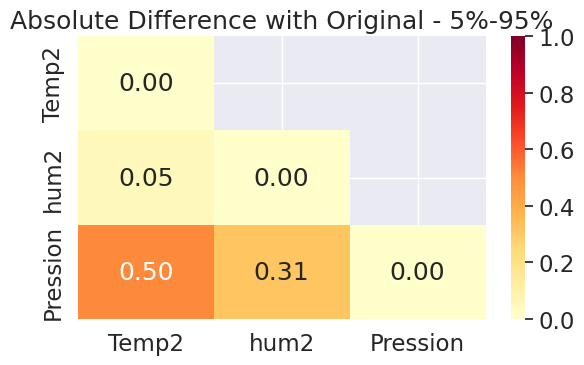

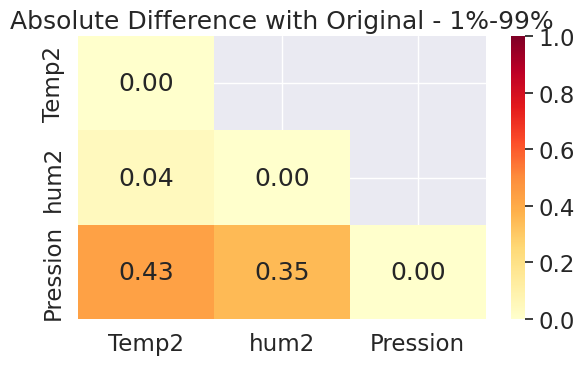

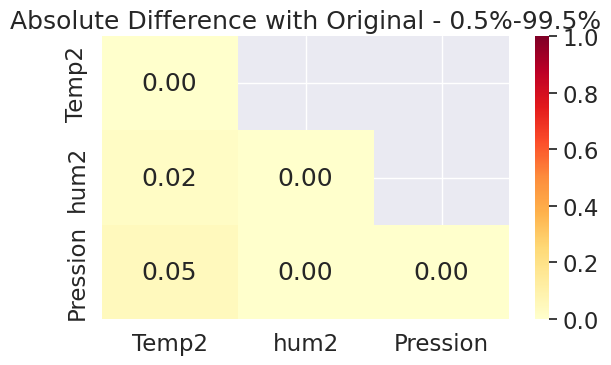

In [110]:
thresholds_cleaned = {
    "5%-95%": Sen2df[
        (Sen2df['Temp2'].between(*Sen2df['Temp2'].quantile([0.05, 0.95]))) &
        (Sen2df['hum2'].between(*Sen2df['hum2'].quantile([0.05, 0.95]))) &
        (Sen2df['Pression'].between(*Sen2df['Pression'].quantile([0.05, 0.95])))
    ],
    "1%-99%": Sen2df[
        (Sen2df['Temp2'].between(*Sen2df['Temp2'].quantile([0.01, 0.99]))) &
        (Sen2df['hum2'].between(*Sen2df['hum2'].quantile([0.01, 0.99]))) &
        (Sen2df['Pression'].between(*Sen2df['Pression'].quantile([0.01, 0.99])))
    ],
    "0.5%-99.5%": Sen2df[
        (Sen2df['Temp2'].between(*Sen2df['Temp2'].quantile([0.005, 0.995]))) &
        (Sen2df['hum2'].between(*Sen2df['hum2'].quantile([0.005, 0.995]))) &
        (Sen2df['Pression'].between(*Sen2df['Pression'].quantile([0.005, 0.995])))
    ]
}

# Calculate the original correlation
corr_original = Sen2df.corr()

# Compare correlations
for label, df_cleaned in thresholds_cleaned.items():
    diff_corr = (df_cleaned.corr() - corr_original).abs()

    plt.figure(figsize=(6, 4))
    sns.heatmap(diff_corr,
                vmin=0, vmax=1,
                annot=True, fmt=".2f", cmap='YlOrRd',
                mask=np.tri(diff_corr.shape[1], k=-1).T)
    plt.title(f'Absolute Difference with Original - {label}')
    plt.tight_layout()
    plt.show()